In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.extmath import cartesian

import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [3]:
#load the files
test = pd.read_csv("D:/Coursera/data/test.csv", index_col=0)
#submission = pd.read_csv("D:/Coursera/data/sample_submission.csv", index_col=0)
#items = pd.read_csv("D:/Coursera/data/items.csv", index_col=1)
#shops = pd.read_csv("D:/Coursera/data/shops.csv", index_col = 1)
#%d.%m.%Y
train = pd.read_csv("D:/Coursera/data/sales_train_v2.csv", parse_dates=[0], dayfirst=True, infer_datetime_format=True, index_col=False)
#sales_train.index.names = ['ID']
#item_categories = pd.read_csv("D:/Coursera/data/item_categories.csv", index_col = 1)

In [4]:
floats = [c for c in train if train[c].dtype == 'float64']
ints = [c for c in train if train[c].dtype == 'int64']
train[floats] = train[floats].astype(np.float32)
train[ints] = train[ints].astype(np.int32)
train['quarter'] = np.int8(pd.DatetimeIndex(train.date).quarter)
train['year'] = np.int32(pd.DatetimeIndex(train.date).year)
train['month'] = np.int8(pd.DatetimeIndex(train.date).month)
train['day'] = np.int8(pd.DatetimeIndex(train.date).day)
train['dayofweek'] = np.int8(pd.DatetimeIndex(train.date).dayofweek)
train['daysinmonth'] = np.int8(pd.DatetimeIndex(train.date).daysinmonth)

In [5]:
train = train.groupby(['date_block_num','year','quarter','month','shop_id','item_id'], as_index=False).agg({'item_cnt_day':['sum','count']})
train.columns = ['date_block_num','year','quarter','month','shop_id','item_id','item_cnt_month','customer_transactions']
train.index.name = 'ID'
train.item_cnt_month = np.clip(train.item_cnt_month, 0, 20)
train.loc[(train.item_cnt_month == 0) & (train.customer_transactions > 0), 'customer_transactions'] = 0

train.date_block_num = np.int8(train.date_block_num)
train.year = np.int32(train.year)
train.quarter = np.int8(train.quarter)
train.month = np.int8(train.month)
train.shop_id = np.int8(train.shop_id)
train.item_id = np.int32(train.item_id)
train.item_cnt_month = np.float32(train.item_cnt_month)
train.customer_transactions = np.float32(train.customer_transactions)

In [6]:
#add zero fills for training
train_temp = []
for i in range(train.date_block_num.min(), (train.date_block_num.max() + 1), 1):
    date_slice = train[(train.date_block_num == i)]
    train_temp.append(np.array(cartesian((date_slice.item_id.unique(), date_slice.shop_id.unique(), [i]))))

train_temp = pd.DataFrame(np.vstack(train_temp), columns = ['item_id','shop_id','date_block_num'], dtype=np.int32)
train = pd.merge(train_temp, train, on=['item_id','shop_id','date_block_num'], how='left').fillna(0.0)

In [7]:
#add prior period item sales and count to TRAIN
shifted_train = train.loc[(train.item_cnt_month > 0), ['shop_id','item_id','date_block_num','item_cnt_month','customer_transactions']].copy()
shifted_train.date_block_num += 1
shifted_train.columns = ['shop_id','item_id','date_block_num','pps_item_cnt_month_lag_1','pps_customer_transactions_lag_1']
train = train.merge(shifted_train, on=['date_block_num','shop_id','item_id'], how='left').fillna(0.0)
del shifted_train

In [7]:
train = train.sort_values(by=['date_block_num','shop_id','item_id'], ascending=True).reset_index(drop=True)
train['ewma_pps_item_cnt_month_lag_1_by_shop_id_item_id'] = train.groupby(['date_block_num','shop_id','item_id']).pps_item_cnt_month_lag_1.transform(lambda x: x.ewm(alpha=0.5, min_periods=0).mean())
train.head()

,item_id,shop_id,date_block_num,year,quarter,month,item_cnt_month,customer_transactions,pps_item_cnt_month_lag_1,pps_customer_transactions_lag_1,ewma_pps_item_cnt_month_lag_1_by_shop_id_item_id
0,19,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,27,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,28,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,32,0,0,2013.0,1.0,1.0,6.0,4.0,0.0,0.0,0.0


# ABOVE  ^^^ TRAIN PREPRATION // BELOW - ANALYSIS

In [59]:
#get a list of unique shop + item combos in TEST not in TRAIN
test = test[['shop_id','item_id']]
shop_items = train[['shop_id','item_id']].drop_duplicates(keep='first')
shop_items['present'] = np.int8(1)
test = test.merge(shop_items, on=['shop_id','item_id'], how='left')
x,y = test[(test.present.isnull() == True)].shape
print("number of unique shop + items in TEST not in TRAIN: %d" % x)
del shop_items
test = test[['shop_id','item_id']]

number of unique shop + items in TEST not in TRAIN: 16102


In [60]:
#get a list of unique items in TEST not in TRAIN
uqitems = len(np.setdiff1d(np.sort(test.item_id.unique()), np.sort(train.item_id.unique())))
print("number of unique items in TEST not in TRAIN: %d" % uqitems)
del uqitems

number of unique items in TEST not in TRAIN: 363


In [61]:
#split train into validation
validation = train[(train.date_block_num == 33)]
train = train[(train.date_block_num < 33)]

In [62]:
#get a list of unique shop + item combos in VALIDATION not in TRAIN
chk = validation[['shop_id','item_id']]
shop_items = train[['shop_id','item_id']].drop_duplicates(keep='first')
shop_items['present'] = np.int8(1)
chk = chk.merge(shop_items, on=['shop_id','item_id'], how='left')
x,y = chk[(chk.present.isnull() == True)].shape
print("number of unique shop + items in VALIDATION not in TRAIN: %d" % x)
del shop_items, chk

number of unique shop + items in VALIDATION not in TRAIN: 29459


In [63]:
#get a list of unique items in VALIDATION not in TRAIN
uqitems = len(np.setdiff1d(np.sort(validation.item_id.unique()), np.sort(train.item_id.unique())))
print("number of unique items in VALIDATION not in TRAIN: %d" % uqitems)
del uqitems

number of unique items in VALIDATION not in TRAIN: 475


In [76]:
print("shape of validation:", validation.shape)
print("shape of test:", test.shape)

shape of validation: (238172, 8)
shape of test: (214200, 2)


In [77]:
join = test.copy()
join = join.merge(validation[['shop_id','item_id','item_cnt_month']], on=['shop_id','item_id'], how='left').fillna(0.0)
print("previous month sales:", join.item_cnt_month.sum())
del join

previous month sales: 54760.0


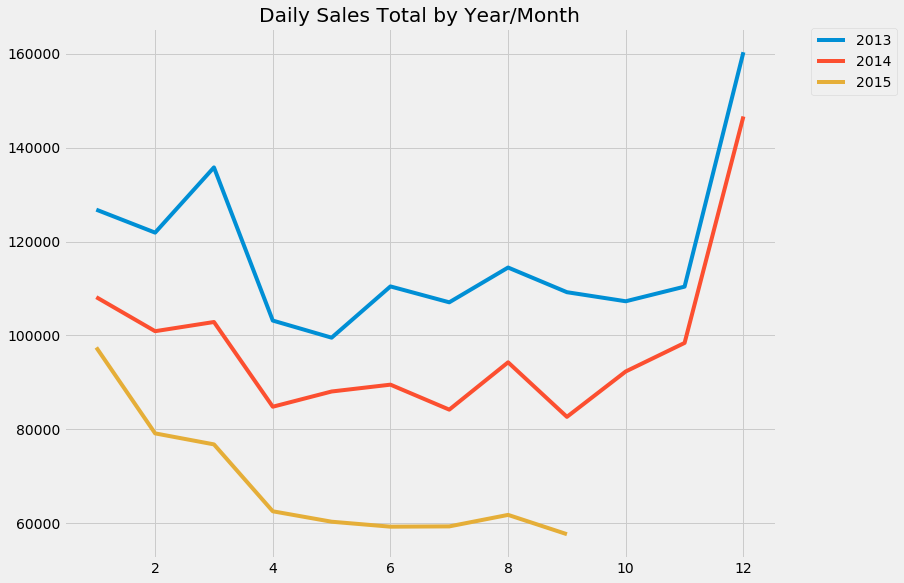

In [78]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(25,20))
plt.subplot(223)
plt.plot(train[(train.year==2013)].groupby([train.month]).agg({'item_cnt_month':'sum'}), label="2013")
plt.plot(train[(train.year==2014)].groupby([train.month]).agg({'item_cnt_month':'sum'}), label="2014")
plt.plot(train[(train.year==2015)].groupby([train.month]).agg({'item_cnt_month':'sum'}), label="2015")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Daily Sales Total by Year/Month")
plt.show()

In [80]:
validation.item_cnt_month.sum()

61583.0

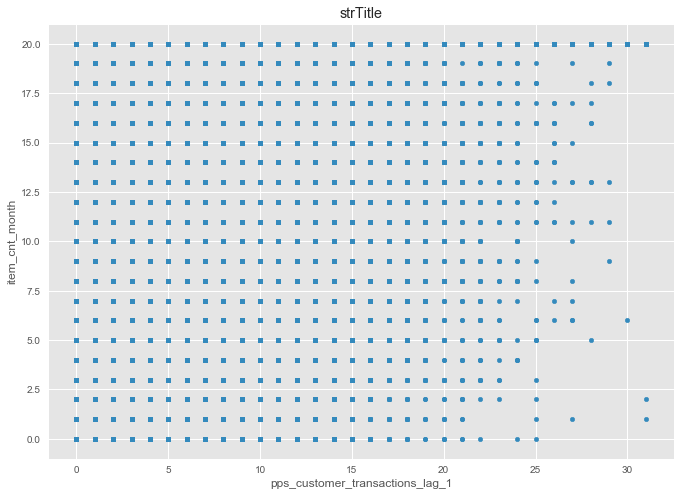

In [106]:
#here, I repopulated train from scratch so it contains the validation set as well.

train.plot.scatter(x='pps_customer_transactions_lag_1',y='item_cnt_month',figsize=(10,8), title='strTitle',style='ggplot')

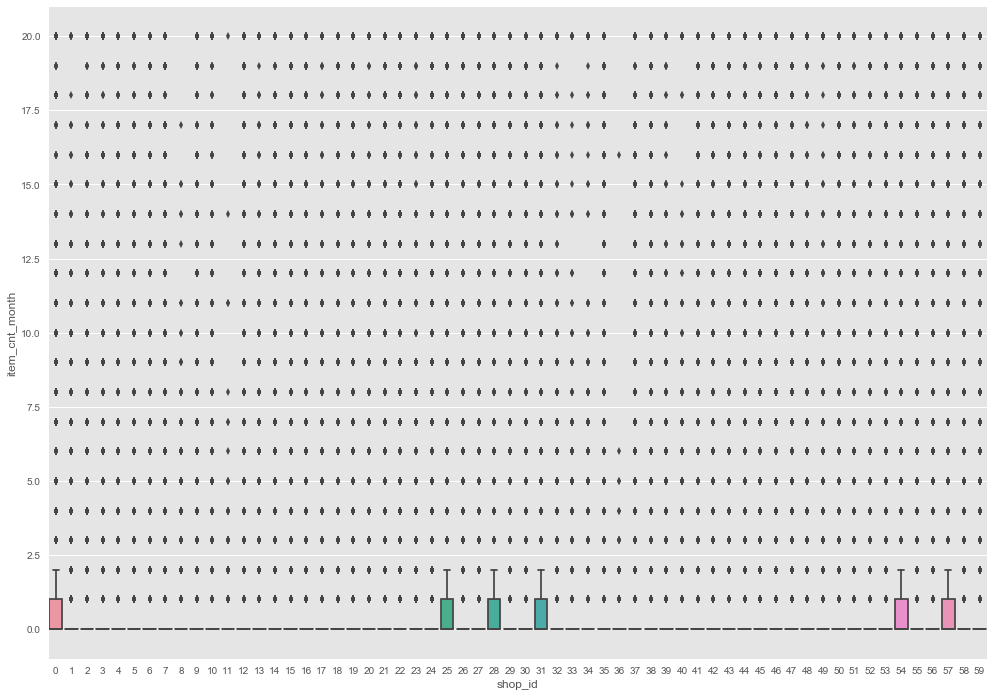

In [108]:
plt.style.use('ggplot')
f, ax = plt.subplots(figsize=(15,12))
fig = sns.boxplot(x='shop_id', y='item_cnt_month', data=train)
plt.show()

In [8]:
corrmat = train.corr()

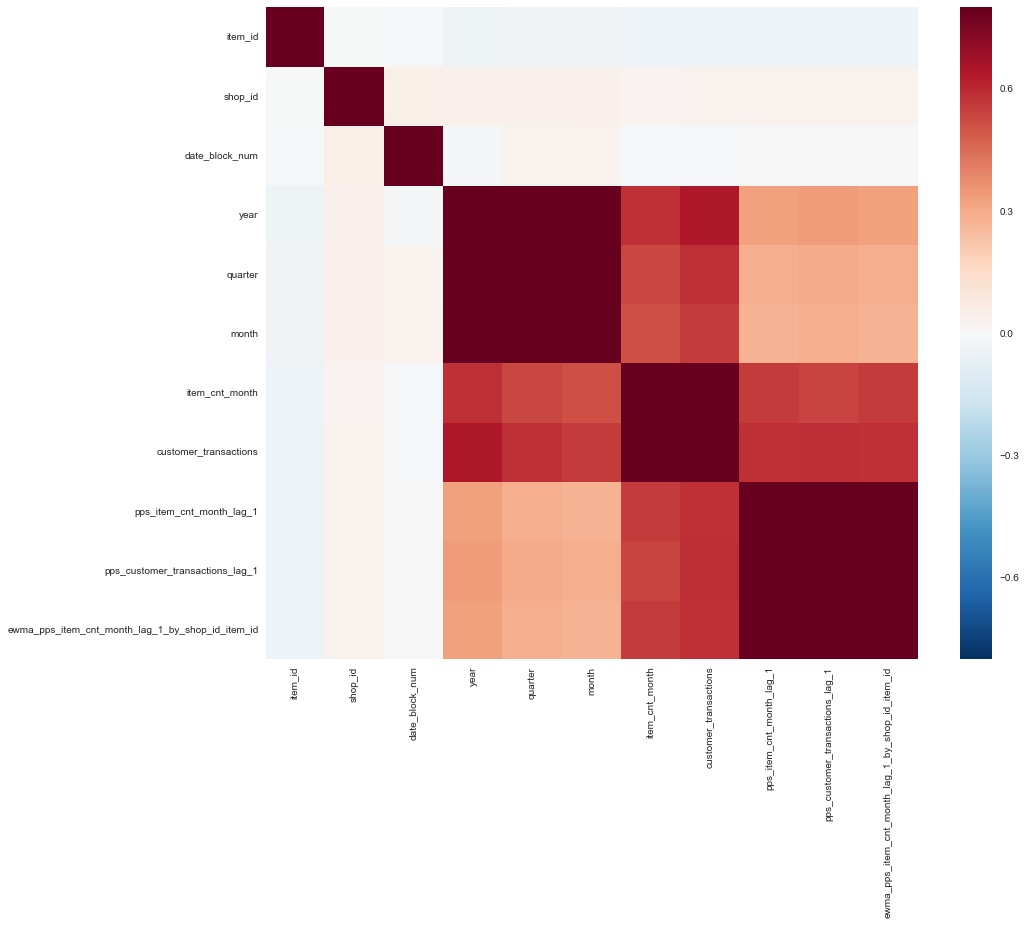

In [9]:
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=0.8, square=True);

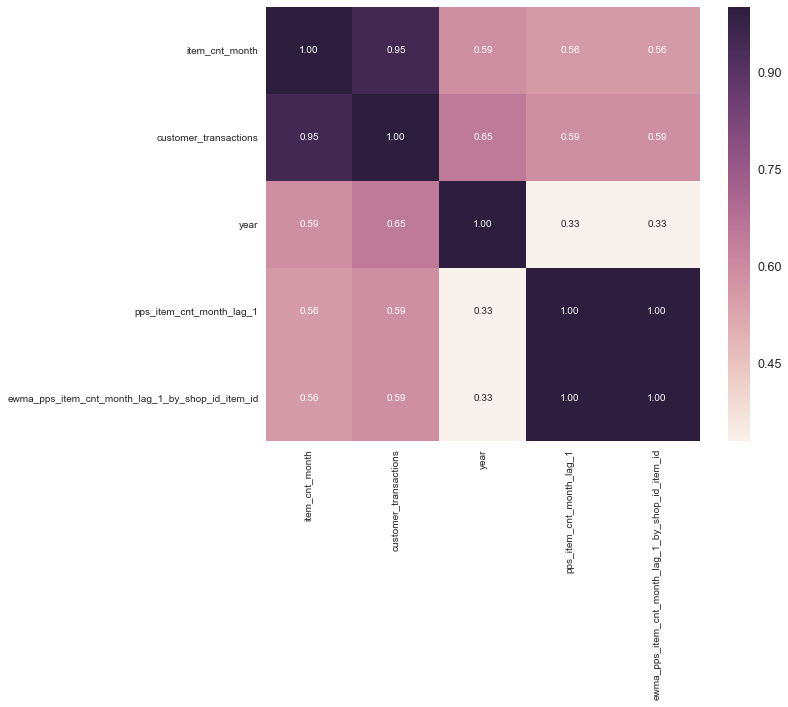

In [10]:
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'item_cnt_month').index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

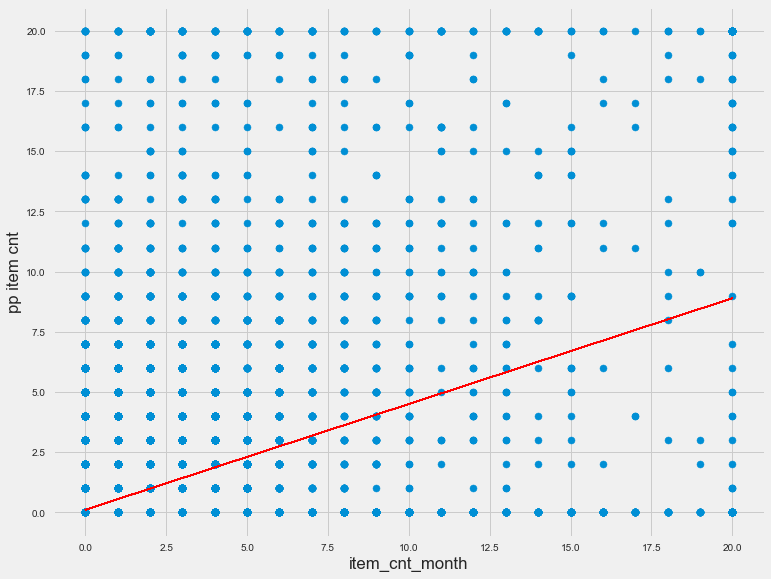

In [18]:
x = train[train.date_block_num==33][['item_cnt_month']]
y = train[train.date_block_num==33].pps_item_cnt_month_lag_1
plt.style.use('fivethirtyeight')
plt.figure(figsize=(25,20))
plt.subplot(223)
regr = LinearRegression()
regr.fit(x, y)
pred = regr.predict(x)
plt.scatter(x=x, y=y)
plt.plot(x, pred, color='red', linewidth=1)
plt.xlabel('item_cnt_month')
plt.ylabel('pp item cnt')
plt.show()